In [1]:
# pip install -q transformers

In [2]:
# pip install transformers[torch]

In [43]:
# pip install datasets

In [4]:
# pip install accelerate -U

## Read Data

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from datasets import load_dataset

ds = load_dataset('aslez123/human_dataset')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8064
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2520
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2016
    })
})

In [6]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=179x282>,
 'label': 11}

In [7]:
train_ds = ds["train"]
val_ds = ds["validation"]
test_ds = ds['test']

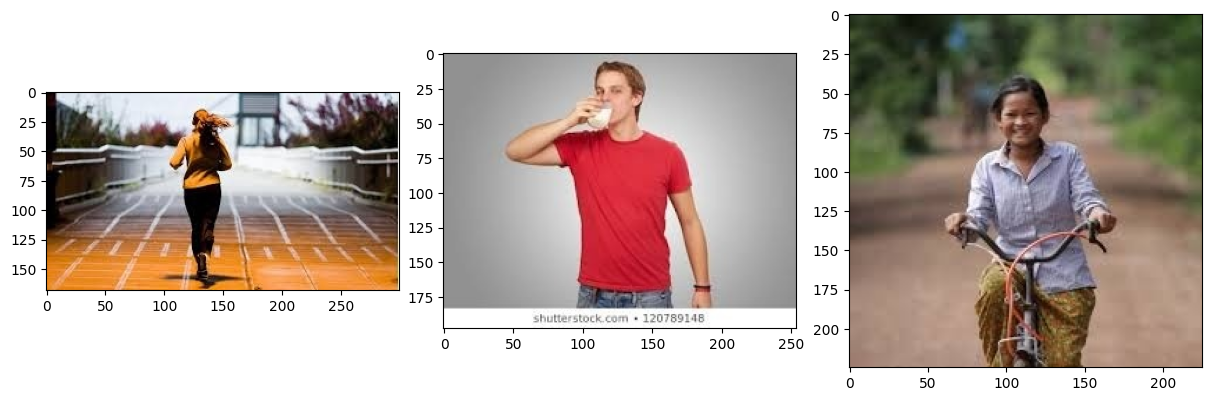

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize = (12,12), constrained_layout=True)

axs[0].imshow(train_ds[3]['image'])
axs[1].imshow(train_ds[5]['image'])
axs[2].imshow(train_ds[12]['image'])

## Zero-shot image classification by hand




In [ ]:
checkpoint = "openai/clip-vit-large-patch14"
class_labels = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing',
                'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

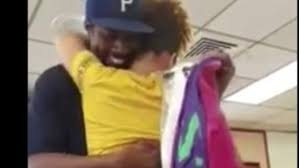

In [ ]:
image = test_ds[20]['image']
image

Process data - resize, normalize and tokanize

In [ ]:
inputs = processor(images=image, text=class_labels, return_tensors="pt", padding=True)

In [5]:
# inputs

In [ ]:
# pixel_values_list = inputs['pixel_values']
# pixel_values_tensor = torch.tensor(pixel_values_list)
# inputs['pixel_values'] = pixel_values_tensor

In [ ]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {'score': score, 'label': label}
    for score, label in sorted(zip(scores, class_labels), key=lambda x: -x[0])
]

In [ ]:
result

[{'score': 0.9834100604057312, 'label': 'hugging'},
 {'score': 0.008276176638901234, 'label': 'laughing'},
 {'score': 0.006018181797116995, 'label': 'dancing'},
 {'score': 0.0008935662335716188, 'label': 'eating'},
 {'score': 0.0005465793656185269, 'label': 'clapping'},
 {'score': 0.0002469064493197948, 'label': 'fighting'},
 {'score': 0.00017949347966350615, 'label': 'listening_to_music'},
 {'score': 0.00011327477841405198, 'label': 'running'},
 {'score': 8.217724098358303e-05, 'label': 'drinking'},
 {'score': 7.65685472288169e-05, 'label': 'calling'},
 {'score': 6.850245699752122e-05, 'label': 'sleeping'},
 {'score': 3.95810893678572e-05, 'label': 'texting'},
 {'score': 2.9690107112401165e-05, 'label': 'sitting'},
 {'score': 1.1518017345224507e-05, 'label': 'using_laptop'},
 {'score': 7.709511010034475e-06, 'label': 'cycling'}]

Fine-tune ViT model

In [ ]:
label2id = {label: id for id, label in enumerate(class_labels)}
id2label = {id: label for id, label in enumerate(class_labels)}

In [ ]:
from transformers import AutoImageProcessor
checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
def transforms(examples):
  examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
  del examples['image']
  return examples

In [ ]:
train_ds = train_ds.with_transform(transforms)
val_ds = val_ds.with_transform(transforms)
test_ds = test_ds.with_transform(transforms)

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

Evaluation

In [ ]:
# pip install evaluate

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(class_labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="human_action_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.673900,1.579035,0.692460
2,1.169600,1.204059,0.746429
3,1.087400,1.095953,0.764286


Checkpoint destination directory human_action_model/checkpoint-126 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory human_action_model/checkpoint-252 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory human_action_model/checkpoint-378 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=378, training_loss=1.5432021302520913, metrics={'train_runtime': 996.8511, 'train_samples_per_second': 24.268, 'train_steps_per_second': 0.379, 'total_flos': 1.874904641610449e+18, 'train_loss': 1.5432021302520913, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/aslez123/human_action_model/commit/38d2feee2ebb6206a68c69a3199365c57a8f4ba1', commit_message='End of training', commit_description='', oid='38d2feee2ebb6206a68c69a3199365c57a8f4ba1', pr_url=None, pr_revision=None, pr_num=None)

Use fine-tuned model for inference using pipeline

In [ ]:
image = ds['test'][77]['image']

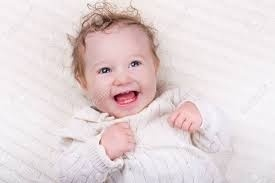

In [ ]:
image

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="aslez123/human_action_model")

In [ ]:
classifier(image)

[{'label': 'laughing', 'score': 0.5610639452934265},
 {'label': 'sleeping', 'score': 0.06321272999048233},
 {'label': 'hugging', 'score': 0.043496325612068176},
 {'label': 'clapping', 'score': 0.04129478335380554},
 {'label': 'drinking', 'score': 0.03050384111702442}]

## Now we want to destill a fine-tuned ViT model (teacher model) to a MobileNet model (student model)


In [8]:
from transformers import AutoImageProcessor
teacher_processor = AutoImageProcessor.from_pretrained("aslez123/human_action_model")

def process(examples):
    processed_inputs = teacher_processor(examples["image"])
    return processed_inputs

processed_datasets = ds.map(process, batched=True)

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Map:   0%|          | 0/8064 [00:00<?, ? examples/s]

Map:   0%|          | 0/2520 [00:00<?, ? examples/s]

Map:   0%|          | 0/2016 [00:00<?, ? examples/s]

In [9]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageDistilTrainer(Trainer):
    def __init__(self, teacher_model=None, student_model=None, temperature=None, lambda_param=None,  *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher.to(device)
        self.teacher.eval()
        self.temperature = temperature
        self.lambda_param = lambda_param

    def compute_loss(self, student, inputs, return_outputs=False):
        student_output = self.student(**inputs)

        with torch.no_grad():
          teacher_output = self.teacher(**inputs)

        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)

        student_target_loss = student_output.loss

        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss

In [10]:
processed_datasets["train"]

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 8064
})

In [11]:
from transformers import AutoModelForImageClassification, MobileNetV2Config, MobileNetV2ForImageClassification

training_args = TrainingArguments(
    output_dir="my-destiled-model",
    num_train_epochs=7,
    fp16=True,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    )

num_labels = len(processed_datasets["train"].features["label"].names)

teacher_model = AutoModelForImageClassification.from_pretrained(
    "aslez123/human_action_model",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

student_config = MobileNetV2Config()
student_config.num_labels = num_labels
student_model = MobileNetV2ForImageClassification(student_config)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [42]:
# pip install evaluate

In [8]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

In [14]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()
trainer = ImageDistilTrainer(
    student_model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    tokenizer=teacher_processor,
    compute_metrics=compute_metrics,
    temperature=5,
    lambda_param=0.5
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.657000,1.495935,0.167063
2,1.578400,1.419534,0.209921
3,1.521000,1.408793,0.226190
4,1.465000,1.455136,0.209921
5,1.414300,1.324579,0.279365
6,1.388600,1.274265,0.301587
7,1.370900,1.721322,0.219841


TrainOutput(global_step=7056, training_loss=1.4850311625301162, metrics={'train_runtime': 7218.2326, 'train_samples_per_second': 7.82, 'train_steps_per_second': 0.978, 'total_flos': 1.1435712258952397e+17, 'train_loss': 1.4850311625301162, 'epoch': 7.0})

In [16]:
trainer.evaluate(processed_datasets["test"])


{'eval_loss': 1.2829787731170654,
 'eval_accuracy': 0.2996031746031746,
 'eval_runtime': 196.4921,
 'eval_samples_per_second': 10.26,
 'eval_steps_per_second': 1.282,
 'epoch': 7.0}

Train a MobileNet model without destillation

In [6]:
from transformers import AutoImageProcessor, MobileNetV2ForImageClassification


In [35]:
image_processor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224")
model = MobileNetV2ForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

In [36]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [37]:
def transforms(examples):
  examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
  del examples['image']
  return examples

In [38]:
train_ds = ds['train']
test_ds = ds['test']

In [39]:
train_ds = train_ds.with_transform(transforms)
test_ds = test_ds.with_transform(transforms)

In [40]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 8064
})

In [41]:
from transformers import TrainingArguments, Trainer
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="mobilenet_fashion",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.721900,2.628029,0.368056
2,2.011200,1.949105,0.451885
3,1.930100,1.901330,0.459821


TrainOutput(global_step=378, training_loss=2.9280149520389616, metrics={'train_runtime': 172.8528, 'train_samples_per_second': 139.957, 'train_steps_per_second': 2.187, 'total_flos': 1.0005875004329165e+17, 'train_loss': 2.9280149520389616, 'epoch': 3.0})